## ***SIMULACIÓN***  
Métodos necesarios para la simulación del inventario

In [5]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

Inicialización de variables

In [6]:
x_1 = 70 #numero de unidades del producto 1
x_2 = 70 #numero de unidades del producto 2
T_simulacion = 5*24*30
#T_simulacion = 5*30*24 #tiempo transcurrido en la simulacion en horas
Tp = 7*24 #cada cuanto pide (cada semana)
lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
         'tpc': 0, # tiempo en el que se ha comprado un pedido
         'tp': 0}  # tiempo en el que ha llegado un pedido
R = 0 #beneficio esperado
P1 = 1000 #numero de unidades max del producto 1
P2 = 1500 #numero de unidades max del producto 2
Nc = 0 #numero de clientes satisfechos
Nnc = 0 # numero de clientes no satisfechos
t0 = 0 # numero de tiempo que el intervalo esta a cero
C = 0 #coste total por pedidos
H = 0 #coste total por almacenamiento
lambda_poisson = 0.5
demanda = [1, 2, 3, 4] #posibles demandas del producto
probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
r_1 = 2.5 #coste al publico del producto 1
r_2 = 3.5 #coste al publico del producto 2
h = 0.0002 #precio sumado por producto y unidad de tiempo
mu = 48 #tiempo de media que tarda un pedido
sigma = 3.5 #desviacion tipica de lo que tarda un pedido
K = 100 #coste fijo del proveedor
n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
p1_1 = 1 # precio si son menos de 600 uds del producto 1
p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
n_descuent_2 = 800
p2_1 = 1.5
p2_2 = 1.25
L = 0 #lo que tarda en llegar el pedido desde que se compra
Lref = 48 #tiempo media de llegada del pedido
lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
t_real = 0
var_aux = 0 # instante en el que el almacen se vacia completamnete
ts = 0 #tiempo de simulacion

#Vectores para la representación gráfica de los niveles de inventario de los dos tipos de producto a lo largo del tiempo

tiempos_1 = [0]
niveles_1 = [70]
tiempos_2 = [0]
niveles_2 = [70]

# datos_grafica [producto 1 o 2] [tiempo (0) o nivel(1)] [i]  
datos_grafica = ["",
                 [[0],[70]], # tiempo y nivel producto 1
                 [[0],[70]]  # tiempo y nivel producto 2
                ]

Métodos para la simulación

In [7]:
def rutina_llegada_cliente(ts):
    global H, h, t_real, x_1, x_2, Nc, Nnc, var_aux, R, Y, y_1, y_2
    global r_1, r_2, var_aux, T_simulacion, tiempos_1, tiempos_2
    global niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Generamos demanda del cliente
    demanda_1 = np.random.choice(demanda, 1, p=probab_1)[0]
    demanda_2 = np.random.choice(demanda, 1, p=probab_2)[0]
  
    #Si hay suficiente almacenado, esta satisfecho
    if demanda_1<=x_1 and demanda_2<=x_2 :
        R += demanda_1*r_1 + demanda_2*r_2 #sube el beneficio
        x_1 -= demanda_1   #baja el inventario
        x_2 -= demanda_2
        Nc += 1 #cliente satisfecho
    #Si no hay suficiente almacenado de algun producto, no esta satisfecho
    else:
        Nnc += 1 #cliente no satisfecho
        if demanda_1 <= x_1:
            R += demanda_1*r_1 
            x_1 -= demanda_1
        elif demanda_2 <= x_2:
            R += demanda_2*r_2 
            x_2 -= demanda_2
    
    # Si se ha vaciado del todo (y antes no estaba vacio) guardamos el tiempo actual
    if x_2 == 0 and x_1 == 0 and var_aux == 0 :
        var_aux = t_real
    
    #Generamos el tiempo que tarda en llegar el siguiente cliente
    Y = stats.poisson.rvs(lambda_poisson, size=1)[0] 
  
    # si el cliente llega antes de acabar la simulacion, se simula
    if Y+t_real < T_simulacion:
        lista['tc'] = t_real+Y 

In [8]:
def rutina_llegada_pedido(ts):
    global H, K, h, t_real, C, t0, var_aux, x_1, x_2, y_1, y_2
    global p1_1, p1_2, p2_1, p2_1, penal, var_aux
    global tiempos_1, tiempos_2, niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Aumenta el nivel de inventario
    x_1 += y_1
    x_2 += y_2
  
    #Si son muchas unidades, descuento en el precio
    Ci_1 = K + y_1 * p1_1 if y_1<=n_descuent_1 else K + y_1 * p1_2
    Ci_2 = K + y_2 * p2_1 if y_2<=n_descuent_2 else K + y_2 * p2_2
  
    #Si llega pronto es mas caro, si llega tarde, es mas barato
    if L < Lref-lim_penal:
        C += (Ci_1 + Ci_2) * (1 + penal)
    elif L > Lref+lim_penal:
        C += (Ci_1 + Ci_2) * (1 - penal)
    else:
        C += Ci_1 + Ci_2
  
    #Ya no quedan productos por llegar
    y_1 = 0
    y_2 = 0
  
    # Si estaba vacio el invenario (se vacio en el instante var_aux),
    # aumenta el tiempo que ha estado vacio.
    if var_aux > 0:
        t0 += t_real - var_aux
        var_aux = 0

In [9]:
def rutina_compra_pedido(ts):
    global H, x_1, x_2, t_real, y_1, y_2, h, t_real
    global P1, P2, lista, T_simulacion

    # Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Cantidad a pedir es lo que falta para llenar el almacen
    y_1 = P1 - x_1
    y_2 = P2 - x_2

    #Generamos cuanto va a tardar en llegar el pedido
    L = np.random.normal(mu, sigma, 1)[0]

    # actualizamos el tiempo de llegada del pedido y el tiempo de siguiente compra
    if L+t_real < T_simulacion:
        lista['tp'] = t_real + L
    
    if t_real+Tp < T_simulacion:
        lista['tpc'] = t_real + Tp

Rutina para la simulación

In [10]:
def simul_main(periodicidad,nivel_1,nivel_2):
    global x_1, x_2, T_simulacion , Tp, lista, R, P1, P2, Nc, Nnc, t0, C, H
    global lambda_poisson, demanda, probab_1, probab_2, r_1, r_2, h, mu, sigma
    global K, n_descuent_1, p1_1, p1_2, p2_1, p2_2, n_descuent_2, L, Lref
    global lim_penal, penal, treal, var_aux, ts
  
    #Reseteamos las variables
    x_1 = 70 #numero de unidades del producto 1
    x_2 = 70 #numero de unidades del producto 2
    T_simulacion = 5*24*30 #tiempo transcurrido en la simulacion en horas
    Tp = periodicidad #cada cuanto pide (cada semana)
    lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
            'tpc': 0, # tiempo en el que se ha comprado un pedido
            'tp': 0}  # tiempo en el que ha llegado un pedido
    R = 0 #beneficio esperado
    P1 = nivel_1 #numero de unidades max del producto 1
    P2 = nivel_2 #numero de unidades max del producto 2
    Nc = 0 #numero de clientes satisfechos
    Nnc = 0 # numero de clientes no satisfechos
    t0 = 0 # numero de tiempo que el intervalo esta a cero
    C = 0 #coste total por pedidos
    H = 0 #coste total por almacenamiento
    lambda_poisson = 0.5
    demanda = [1, 2, 3, 4] #posibles demandas del producto
    probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
    probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
    r_1 = 2.5 #coste al publico del producto 1
    r_2 = 3.5 #coste al publico del producto 2
    h = 0.0002 #precio sumado por producto y unidad de tiempo
    mu = 48 #tiempo de media que tarda un pedido
    sigma = 3.5 #desviacion tipica de lo que tarda un pedido
    K = 100 #coste fijo del proveedor
    n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
    p1_1 = 1 # precio si son menos de 600 uds del producto 1
    p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
    n_descuent_2 = 800
    p2_1 = 1.5
    p2_2 = 1.25
    
    L = 0 #lo que tarda en llegar el pedido desde que se compra
    Lref = 48 #tiempo media de llegada del pedido
    lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
    penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
    t_real = 0
    var_aux = 0 # instante en el que el almacen se vacia completamnete
    ts = 0 #tiempo de simulacion
  
    # Iniciamos siumlacion
    ts = 0
    lista['tc'] = 4000
    lista['tp'] = 4000
    lista['tpc'] = Tp
    
    #Generamos el tiempo que tarda en llegar el primer cliente
    Z = stats.poisson.rvs(lambda_poisson, size=1)[0]

    #Si el tiempo si pasa del limite T, la simulación se acaba
    if Z > T_simulacion: return -1
  
    #print('** Llega el primer cliente')
    rutina_llegada_cliente(Z)
  
    #Repetir si siguen llegando clientes o siguen llegando pedidos
    while (lista['tc']!=4000 or lista['tp']!=4000) and ts <= T_simulacion:
    
        #Si el siguiente evento es la llegada de un cliente
        if lista['tc'] <= lista['tpc'] and lista['tc'] <= lista['tp']:
            ts = lista['tc']
            lista['tc'] = 4000
            rutina_llegada_cliente(ts)

        #Si el siguiente evento es la compra de un pedido 
        elif(lista['tpc']<=lista['tc'] and lista['tpc']<=lista['tp']):
            ts = lista['tpc']
            lista['tpc'] = 4000
            rutina_compra_pedido(ts)

        #Si el siguiente evento es una llegada de pedido
        elif(lista['tp']<=lista['tc'] and lista['tp']<=lista['tpc']):
            ts = lista['tp']
            lista['tp'] = 4000
            rutina_llegada_pedido(ts)
      
    benef = R - C - H                #Beneficios
    cl_satisf = Nc / (Nc + Nnc) *100 #Porcentaje de clientes satisfechos
    t0_tot = t0 / T_simulacion       #Tiempo que ha estado el almacen vacio
  
    return benef

## ***RECOCIDO SIMULADO*** 

In [11]:
import random
import math
import matplotlib

In [12]:
def buscando_temperatura(T,initial_state):
    lista_temp = []
    lista_prob = []
 
    while T > 7000:
        neighbor = get_neighbor(initial_state)
        initial_state["benef"] = get_benef(initial_state)
        neighbor["benef"] = get_benef(neighbor)
        benef_diff = neighbor["benef"] - initial_state["benef"]
        prob = math.exp( - abs(benef_diff) / T)
        lista_temp.append(T)
        lista_prob.append(prob)
        T-=10
    grafica('Temperatura inicial','Probabilidad',lista_temp,lista_prob)

In [13]:
def grafica(titulox,tituloy,x,*args):
    for n in args:
        plt.plot(x,n)
    plt.xlabel(titulox)
    plt.ylabel(tituloy)
    plt.show()

In [25]:
def recocido_simulado(initial_state):
    # HIPERPARAMETERS
    alpha = 0.95 #Ritmo de decrecimiento de la temperatura
    initial_temp = 7500
    max_it_sin_cambio = 300
    #final_temp = 300
    it_sin_cambio = 0 # Numero de iteraciones sin cambio, max 10
    L = 0 #Num de iteraciones donde mantenemos la temperatura
    iteraciones = 1 #Contador de iteraciones
    
    #Variables graficas
    lista_benef = []
    lista_temp = []
    lista_prob = []
    lista_sol = []
    lista_niv_1 = []
    lista_niv_2 =[]
    lista_periodo = []

    # Primera iteracion
    current_temp = initial_temp
    current_state = initial_state
    current_state["benef"] = get_benef(current_state)
    best_state = current_state
    
    while it_sin_cambio < max_it_sin_cambio:
        # Comprobar si el vecino es mejor
        neighbor = get_neighbor(current_state)
        neighbor["benef"] = get_benef(neighbor)

        benef_diff = neighbor["benef"] - current_state["benef"]
        prob = math.exp(-abs(benef_diff) / current_temp)

        # Si es mejor, aceptamos vecino
        # Si es peor, aceptamos si p>u
        if benef_diff > 0 or random.uniform(0, 1) < prob:
            current_state = neighbor
                        
        print("It."+str(iteraciones)+
                 "\tTemp.: "+str(int(current_temp))+
                    "\tProb.: "+str(prob)+
                    "\tBeneficio: "+str(current_state["benef"])+
                    "\tParametros: "+str(current_state["periodicidad"])+", "+
                                                        str(current_state["nivel_1"])+", "+
                                                        str(current_state["nivel_2"]))

        
        
        lista_benef.append(best_state['benef'])
        lista_temp.append(current_temp)
        lista_prob.append(prob)
        lista_sol.append(current_state['benef'])
        lista_niv_1.append(current_state['nivel_1'])
        lista_niv_2.append(current_state['nivel_2'])
        lista_periodo.append(current_state['periodicidad'])

        # Bajamos temperatura
        if L==10:
            current_temp = current_temp * alpha
            L=0
        
        iteraciones += 1
        L += 1
        it_sin_cambio +=1 
        
        if best_state["benef"] < current_state["benef"]:
            best_state = current_state
            it_sin_cambio = 0
        
    grafica('Iteraciones','Mejor Solucion',range(1,iteraciones),lista_benef)
    grafica('Iteraciones','Temperatura',range(1,iteraciones),lista_temp)
    grafica('Iteraciones','Funcion fitness',range(1,iteraciones),lista_sol)
    grafica('Iteraciones','Factores de decision',range(1,iteraciones),lista_niv_1,lista_niv_2,lista_periodo)
    grafica('Iteraciones','Probabilidades',range(1,iteraciones),lista_prob)
    return best_state

In [21]:
def get_benef(state):
        return simul_main(state["periodicidad"], state["nivel_1"], state["nivel_2"])

In [22]:
def get_neighbor(state):
        """Returns neighbors of the argument state for your solution."""
        new_periodicidad = state["periodicidad"] + np.random.uniform(-1,1)
        new_nivel_1 = state["nivel_1"] + random.randint(-3,3)
        new_nivel_2 = state["nivel_2"] + random.randint(-3,3)

        neighbor = {'periodicidad':new_periodicidad ,    
                                            'nivel_1': new_nivel_1,
                                            'nivel_2': new_nivel_2 }

        return neighbor

It.1	Temp.: 7500	Prob.: 0.8304150553907127	Beneficio: 53672.133431381764	Parametros: 167.7811043836341, 1497, 1003
It.2	Temp.: 7500	Prob.: 0.9216824523490694	Beneficio: 53672.133431381764	Parametros: 167.7811043836341, 1497, 1003
It.3	Temp.: 7500	Prob.: 0.6990918698628946	Beneficio: 53672.133431381764	Parametros: 167.7811043836341, 1497, 1003
It.4	Temp.: 7500	Prob.: 0.9166739596186321	Beneficio: 53019.60777332917	Parametros: 168.0921549503322, 1500, 1004
It.5	Temp.: 7500	Prob.: 0.964852666123722	Beneficio: 52751.258771642475	Parametros: 167.76467117955, 1502, 1001
It.6	Temp.: 7500	Prob.: 0.940118300484533	Beneficio: 52751.258771642475	Parametros: 167.76467117955, 1502, 1001
It.7	Temp.: 7500	Prob.: 0.953432930461782	Beneficio: 53108.905247498944	Parametros: 168.01437638138438, 1504, 998
It.8	Temp.: 7500	Prob.: 0.869758898623539	Beneficio: 52062.36099430274	Parametros: 168.23086178225233, 1503, 997
It.9	Temp.: 7500	Prob.: 0.8691588541006208	Beneficio: 53114.08126470097	Parametros: 167.62

It.73	Temp.: 5237	Prob.: 0.7637867748208206	Beneficio: 51883.443626555774	Parametros: 165.05669742818952, 1511, 949
It.74	Temp.: 5237	Prob.: 0.9326332403291612	Beneficio: 51518.16126824592	Parametros: 165.52223538933117, 1512, 947
It.75	Temp.: 5237	Prob.: 0.923721215025319	Beneficio: 51933.73289741439	Parametros: 165.6402031711621, 1511, 945
It.76	Temp.: 5237	Prob.: 0.719133430942572	Beneficio: 53660.590231959046	Parametros: 166.56001911586674, 1509, 944
It.77	Temp.: 5237	Prob.: 0.47742420121237905	Beneficio: 49788.22330033104	Parametros: 166.8328637688091, 1511, 941
It.78	Temp.: 5237	Prob.: 0.9185631737717436	Beneficio: 49343.32344678925	Parametros: 166.07991316202254, 1510, 942
It.79	Temp.: 5237	Prob.: 0.6198424294859105	Beneficio: 51848.38142814197	Parametros: 166.63319644838768, 1512, 945
It.80	Temp.: 5237	Prob.: 0.8935695840511408	Beneficio: 52437.76624836469	Parametros: 166.37775376875442, 1513, 947
It.81	Temp.: 5237	Prob.: 0.9547498967363208	Beneficio: 52437.76624836469	Parametr

It.144	Temp.: 3657	Prob.: 0.674824000696986	Beneficio: 53785.35267281049	Parametros: 167.0857958896764, 1513, 963
It.145	Temp.: 3657	Prob.: 0.5055104860406461	Beneficio: 53785.35267281049	Parametros: 167.0857958896764, 1513, 963
It.146	Temp.: 3657	Prob.: 0.7105213653263641	Beneficio: 52535.357841730234	Parametros: 166.90603264550725, 1513, 962
It.147	Temp.: 3657	Prob.: 0.8031992517701863	Beneficio: 51733.79405070359	Parametros: 167.1448604934993, 1514, 960
It.148	Temp.: 3657	Prob.: 0.6583568845150249	Beneficio: 53262.68479869366	Parametros: 166.89252619287026, 1511, 957
It.149	Temp.: 3657	Prob.: 0.5383689473773576	Beneficio: 50997.88131121965	Parametros: 167.1024643894865, 1508, 960
It.150	Temp.: 3657	Prob.: 0.7761417096751125	Beneficio: 51924.78134515783	Parametros: 167.2245258038435, 1510, 961
It.151	Temp.: 3657	Prob.: 0.8501337463952053	Beneficio: 51330.933695949985	Parametros: 167.84060238647308, 1508, 962
It.152	Temp.: 3474	Prob.: 0.7825931679581241	Beneficio: 52182.72577605763	Pa

It.215	Temp.: 2554	Prob.: 0.5462490062528944	Beneficio: 51561.06630734301	Parametros: 163.29952344104245, 1503, 964
It.216	Temp.: 2554	Prob.: 0.2648577212354972	Beneficio: 54954.49684487718	Parametros: 164.24811781090028, 1500, 967
It.217	Temp.: 2554	Prob.: 0.6829654161441544	Beneficio: 54954.49684487718	Parametros: 164.24811781090028, 1500, 967
It.218	Temp.: 2554	Prob.: 0.49080534636310297	Beneficio: 53136.64442557432	Parametros: 164.08320606396148, 1500, 966
It.219	Temp.: 2554	Prob.: 0.8062240483548472	Beneficio: 53686.8053845494	Parametros: 164.71115299297557, 1501, 964
It.220	Temp.: 2554	Prob.: 0.48282846053581424	Beneficio: 53686.8053845494	Parametros: 164.71115299297557, 1501, 964
It.221	Temp.: 2554	Prob.: 0.767763965381633	Beneficio: 53686.8053845494	Parametros: 164.71115299297557, 1501, 964
It.222	Temp.: 2426	Prob.: 0.9895540963973484	Beneficio: 53661.32506749627	Parametros: 163.77673680630363, 1499, 966
It.223	Temp.: 2426	Prob.: 0.6684377471069656	Beneficio: 52683.90108578114	

It.286	Temp.: 1783	Prob.: 0.9223896157974262	Beneficio: 53168.97325311028	Parametros: 157.24032588523633, 1495, 975
It.287	Temp.: 1783	Prob.: 0.3198354022894883	Beneficio: 55202.301766849756	Parametros: 157.30292035114758, 1493, 977
It.288	Temp.: 1783	Prob.: 0.3637599125304262	Beneficio: 55202.301766849756	Parametros: 157.30292035114758, 1493, 977
It.289	Temp.: 1783	Prob.: 0.1958853227606889	Beneficio: 55202.301766849756	Parametros: 157.30292035114758, 1493, 977
It.290	Temp.: 1783	Prob.: 0.27525625604209214	Beneficio: 55202.301766849756	Parametros: 157.30292035114758, 1493, 977
It.291	Temp.: 1783	Prob.: 0.20120663543383058	Beneficio: 55202.301766849756	Parametros: 157.30292035114758, 1493, 977
It.292	Temp.: 1694	Prob.: 0.6357810602309057	Beneficio: 54434.85348986807	Parametros: 157.5092195883585, 1493, 976
It.293	Temp.: 1694	Prob.: 0.5150571568348985	Beneficio: 53310.5800495167	Parametros: 158.47855490546536, 1493, 979
It.294	Temp.: 1694	Prob.: 0.7034148839060839	Beneficio: 52714.43489

It.357	Temp.: 1245	Prob.: 0.31121747826585683	Beneficio: 56249.57303805112	Parametros: 161.8548745040118, 1474, 1002
It.358	Temp.: 1245	Prob.: 0.28763922171664436	Beneficio: 54697.46366778898	Parametros: 161.6434644041557, 1475, 1003
It.359	Temp.: 1245	Prob.: 0.5016102136916024	Beneficio: 55556.86038727384	Parametros: 161.5905530686182, 1475, 1001
It.360	Temp.: 1245	Prob.: 0.03299994168533496	Beneficio: 55556.86038727384	Parametros: 161.5905530686182, 1475, 1001
It.361	Temp.: 1245	Prob.: 0.20928881751801076	Beneficio: 55556.86038727384	Parametros: 161.5905530686182, 1475, 1001
It.362	Temp.: 1183	Prob.: 0.2881755887607109	Beneficio: 54084.56103794307	Parametros: 161.71976537921216, 1473, 999
It.363	Temp.: 1183	Prob.: 0.8318216743960678	Beneficio: 53866.66337288587	Parametros: 160.73810503604614, 1470, 999
It.364	Temp.: 1183	Prob.: 0.5044180116229907	Beneficio: 53866.66337288587	Parametros: 160.73810503604614, 1470, 999
It.365	Temp.: 1183	Prob.: 0.14534786637074248	Beneficio: 53866.66337

It.428	Temp.: 869	Prob.: 0.19240024078616144	Beneficio: 54489.31228385804	Parametros: 164.67459142767285, 1463, 986
It.429	Temp.: 869	Prob.: 0.8592408431540461	Beneficio: 54357.34827489143	Parametros: 165.45051105874316, 1461, 985
It.430	Temp.: 869	Prob.: 0.27982529159868674	Beneficio: 54357.34827489143	Parametros: 165.45051105874316, 1461, 985
It.431	Temp.: 869	Prob.: 0.048335275697620826	Beneficio: 54357.34827489143	Parametros: 165.45051105874316, 1461, 985
It.432	Temp.: 826	Prob.: 0.7405423870295087	Beneficio: 54109.12853062687	Parametros: 164.84026163336426, 1463, 983
It.433	Temp.: 826	Prob.: 0.7318026204146045	Beneficio: 54367.15901192006	Parametros: 165.61306093365246, 1461, 980
It.434	Temp.: 826	Prob.: 0.24471809109175963	Beneficio: 54367.15901192006	Parametros: 165.61306093365246, 1461, 980
It.435	Temp.: 826	Prob.: 0.07174655924610174	Beneficio: 54367.15901192006	Parametros: 165.61306093365246, 1461, 980
It.436	Temp.: 826	Prob.: 0.057294316539822365	Beneficio: 54367.15901192006

It.499	Temp.: 607	Prob.: 0.04337520379327482	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.500	Temp.: 607	Prob.: 0.04171632308337291	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.501	Temp.: 607	Prob.: 0.04166394844691014	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.502	Temp.: 577	Prob.: 0.004354424675305866	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.503	Temp.: 577	Prob.: 0.1675443548525273	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.504	Temp.: 577	Prob.: 0.007895567148680442	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.505	Temp.: 577	Prob.: 0.002547245496319057	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.506	Temp.: 577	Prob.: 0.00916679974814296	Beneficio: 55869.27801997182	Parametros: 164.88368777617762, 1452, 976
It.507	Temp.: 577	Prob.: 0.006122870418267352	Beneficio: 55869.2780199

It.569	Temp.: 424	Prob.: 0.10048065476044159	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.570	Temp.: 424	Prob.: 0.041528443671510436	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.571	Temp.: 424	Prob.: 0.009886021849477648	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.572	Temp.: 403	Prob.: 0.009499014199967891	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.573	Temp.: 403	Prob.: 0.0010048101873134767	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.574	Temp.: 403	Prob.: 0.0076597055073231	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.575	Temp.: 403	Prob.: 0.004701297385032822	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.576	Temp.: 403	Prob.: 0.010401835696612205	Beneficio: 55616.25527899862	Parametros: 163.50122132881563, 1453, 986
It.577	Temp.: 403	Prob.: 0.03466207836083108	Beneficio: 55616.2552

It.639	Temp.: 296	Prob.: 5.5052554626193036e-05	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.640	Temp.: 296	Prob.: 2.1407119373491117e-05	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.641	Temp.: 296	Prob.: 0.12815815379091958	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.642	Temp.: 281	Prob.: 0.0017395463306936546	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.643	Temp.: 281	Prob.: 0.0026941717355692244	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.644	Temp.: 281	Prob.: 5.896693607001285e-06	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.645	Temp.: 281	Prob.: 6.443418852354649e-05	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.646	Temp.: 281	Prob.: 0.0003087762358817078	Beneficio: 56493.1549052718	Parametros: 162.1863304352185, 1453, 990
It.647	Temp.: 281	Prob.: 0.0003788492601529647	Beneficio: 56493.15490527

It.710	Temp.: 206	Prob.: 0.00019387463482751816	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.711	Temp.: 206	Prob.: 3.440063072145773e-09	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.712	Temp.: 196	Prob.: 4.108316494221232e-09	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.713	Temp.: 196	Prob.: 0.004334985412706362	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.714	Temp.: 196	Prob.: 2.7216812070590306e-12	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.715	Temp.: 196	Prob.: 3.2518320788054364e-08	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.716	Temp.: 196	Prob.: 0.037257057495826265	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.717	Temp.: 196	Prob.: 2.1178354288582307e-05	Beneficio: 56372.08980748647	Parametros: 162.05501130770995, 1453, 988
It.718	Temp.: 196	Prob.: 5.045276612163366e-07	Benefic

It.780	Temp.: 144	Prob.: 0.0017148387550214531	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.781	Temp.: 144	Prob.: 7.312445397454649e-05	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.782	Temp.: 137	Prob.: 3.9124571335875245e-08	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.783	Temp.: 137	Prob.: 1.599718811550041e-05	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.784	Temp.: 137	Prob.: 1.74406123437664e-06	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.785	Temp.: 137	Prob.: 8.960862880283769e-09	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.786	Temp.: 137	Prob.: 1.1706432266513884e-06	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.787	Temp.: 137	Prob.: 2.92189597557572e-07	Beneficio: 56465.37663465971	Parametros: 162.16005784007407, 1452, 991
It.788	Temp.: 137	Prob.: 7.844305113063063e-05	Beneficio

It.849	Temp.: 100	Prob.: 1.2506666542856175e-09	Beneficio: 56444.042700100894	Parametros: 162.13399882016822, 1452, 990
It.850	Temp.: 100	Prob.: 1.8222949418565498e-12	Beneficio: 56444.042700100894	Parametros: 162.13399882016822, 1452, 990
It.851	Temp.: 100	Prob.: 4.858349953993477e-08	Beneficio: 56444.042700100894	Parametros: 162.13399882016822, 1452, 990
It.852	Temp.: 95	Prob.: 1.185730907216613e-18	Beneficio: 56444.042700100894	Parametros: 162.13399882016822, 1452, 990
It.853	Temp.: 95	Prob.: 0.0016489859947885837	Beneficio: 57058.17614392235	Parametros: 162.47469940589616, 1455, 991
It.854	Temp.: 95	Prob.: 2.5800183057947556e-11	Beneficio: 57058.17614392235	Parametros: 162.47469940589616, 1455, 991
It.855	Temp.: 95	Prob.: 0.5730805884072045	Beneficio: 57111.53561327928	Parametros: 162.78128167140682, 1458, 994
It.856	Temp.: 95	Prob.: 2.0875340078301417e-14	Beneficio: 57111.53561327928	Parametros: 162.78128167140682, 1458, 994
It.857	Temp.: 95	Prob.: 6.01799074035399e-12	Beneficio: 

It.919	Temp.: 70	Prob.: 2.2206975998103116e-19	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.920	Temp.: 70	Prob.: 8.207377173657443e-21	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.921	Temp.: 70	Prob.: 5.668648987080331e-27	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.922	Temp.: 66	Prob.: 7.819680929732411e-26	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.923	Temp.: 66	Prob.: 3.824064906596603e-27	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.924	Temp.: 66	Prob.: 6.307655617779908e-23	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.925	Temp.: 66	Prob.: 8.461088984582591e-15	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.926	Temp.: 66	Prob.: 1.1617351812051561e-21	Beneficio: 57211.583102130935	Parametros: 162.7032443413885, 1459, 995
It.927	Temp.: 66	Prob.: 3.218191499299218e-14	Beneficio: 57211

It.989	Temp.: 49	Prob.: 2.4788609372799086e-41	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.990	Temp.: 49	Prob.: 1.5264775032126636e-11	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.991	Temp.: 49	Prob.: 5.901761763558943e-32	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.992	Temp.: 46	Prob.: 6.841057788612396e-41	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.993	Temp.: 46	Prob.: 4.4435093338093485e-29	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.994	Temp.: 46	Prob.: 5.891529904230285e-32	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.995	Temp.: 46	Prob.: 3.392237937940304e-41	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.996	Temp.: 46	Prob.: 2.6024805871526034e-35	Beneficio: 57414.455379700696	Parametros: 163.08831546719776, 1459, 997
It.997	Temp.: 46	Prob.: 4.818241202975461e-26	Benefi

It.1058	Temp.: 34	Prob.: 7.740520250899407e-18	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1059	Temp.: 34	Prob.: 5.145326717145487e-33	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1060	Temp.: 34	Prob.: 3.397383961128791e-53	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1061	Temp.: 34	Prob.: 2.1346838824852875e-51	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1062	Temp.: 32	Prob.: 1.3359220037024898e-47	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1063	Temp.: 32	Prob.: 1.1196881530701913e-42	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1064	Temp.: 32	Prob.: 2.0227224716000822e-48	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1065	Temp.: 32	Prob.: 7.454945574248326e-13	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1066	Temp.: 32	Prob.: 1.0177240162990905e

It.1127	Temp.: 23	Prob.: 1.5008594945851333e-49	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1128	Temp.: 23	Prob.: 6.865805914824934e-84	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1129	Temp.: 23	Prob.: 3.336553311356999e-56	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1130	Temp.: 23	Prob.: 1.1201045530862295e-68	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1131	Temp.: 23	Prob.: 1.4183610592579166e-54	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1132	Temp.: 22	Prob.: 1.811870269862225e-98	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1133	Temp.: 22	Prob.: 4.165244857409126e-43	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1134	Temp.: 22	Prob.: 8.323652924207598e-76	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1135	Temp.: 22	Prob.: 4.188760968236901e-7

It.1196	Temp.: 16	Prob.: 1.6060503126330982e-135	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1197	Temp.: 16	Prob.: 3.2848562079797824e-71	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1198	Temp.: 16	Prob.: 4.2690104097361465e-105	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1199	Temp.: 16	Prob.: 1.715811653841263e-112	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1200	Temp.: 16	Prob.: 1.0750452609386757e-78	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1201	Temp.: 16	Prob.: 3.295471013567419e-70	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1202	Temp.: 15	Prob.: 1.2192455981877848e-132	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1203	Temp.: 15	Prob.: 2.2253987814034937e-79	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1204	Temp.: 15	Prob.: 3.22672558037

It.1265	Temp.: 11	Prob.: 1.1380075580708258e-146	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1266	Temp.: 11	Prob.: 3.224538888197586e-141	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1267	Temp.: 11	Prob.: 1.2175682416704706e-71	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1268	Temp.: 11	Prob.: 2.30143211386433e-146	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1269	Temp.: 11	Prob.: 3.504060957199516e-97	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1270	Temp.: 11	Prob.: 3.5998648938410305e-184	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1271	Temp.: 11	Prob.: 1.9327680010394036e-99	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1272	Temp.: 11	Prob.: 3.195146016049712e-92	Beneficio: 57533.00407797991	Parametros: 163.67125150143673, 1461, 1000
It.1273	Temp.: 11	Prob.: 2.66300368688605

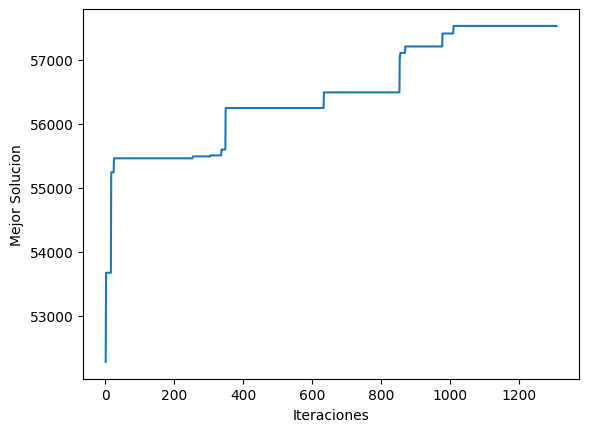

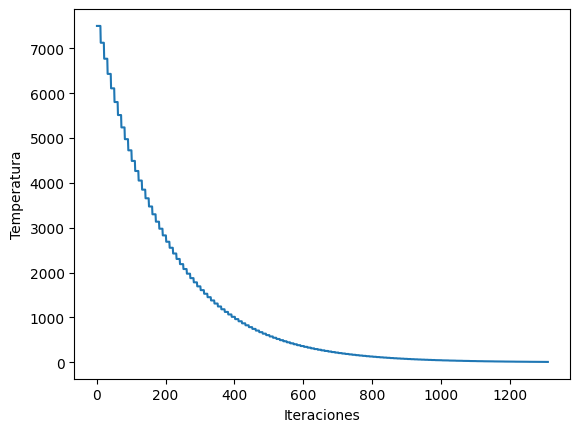

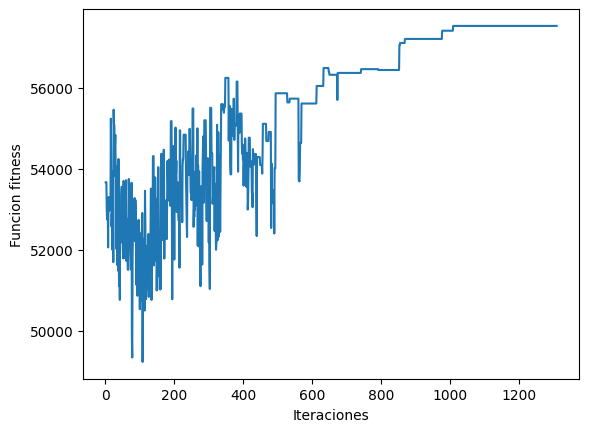

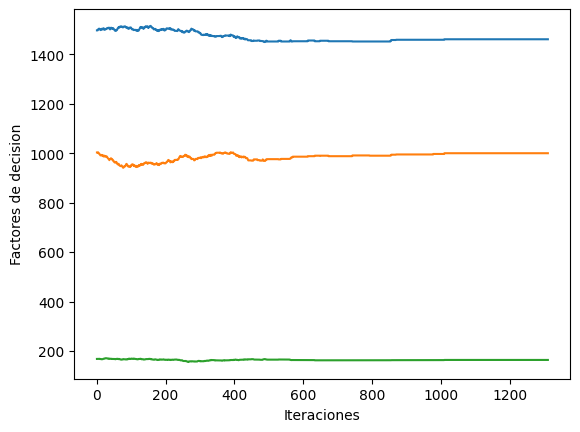

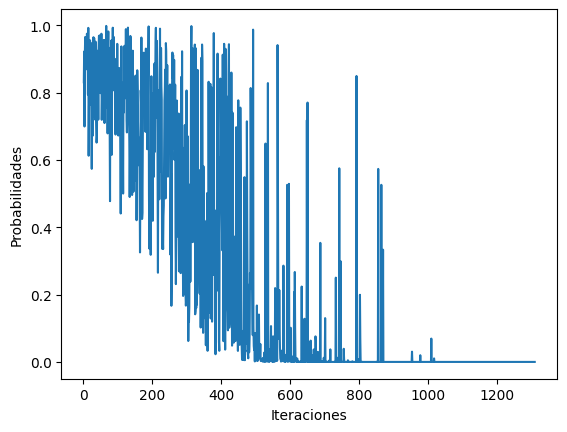

{'periodicidad': 163.67125150143673,
 'nivel_1': 1461,
 'nivel_2': 1000,
 'benef': 57533.00407797991}

In [26]:
initial_state = {'periodicidad': 168 ,  
                      'nivel_1': 1500,
                      'nivel_2': 1000 }

recocido_simulado(initial_state)

In [24]:
initial_state = {'periodicidad':168 ,  
                      'nivel_1': 1500,
                      'nivel_2': 1000 }
buscando_temperatura(8000, initial_state)